## Data Analytics - Lab 5 - Using link functions to create generalized linear models
<br>
Jan Pomykacz<br>
Nr. albumu: 401623<br>
Grupa: czwartek, 9:30

In [2]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Reading Data

In [55]:
pd_data = pd.read_csv('Airline_data.csv')
print(pd_data)
print(pd_data.describe())

   Year  Fatal accidents  Passenger deaths  Miles flown [100 mln miles]
0  1976               24               734                       3863.0
1  1977               25               516                       4300.0
2  1978               31               754                       5027.0
3  1979               31               877                       5481.0
4  1980               22               814                       5814.0
5  1981               21               362                       6033.0
6  1982               26               764                       5877.0
7  1983               20               809                       6223.0
8  1984               16               223                       7433.0
9  1985               22              1066                       7107.0
             Year  Fatal accidents  Passenger deaths  \
count    10.00000        10.000000         10.000000   
mean   1980.50000        23.800000        691.900000   
std       3.02765         4.709329      

### Prior value check
To see what values can exp function get with different intercepts

INFO:cmdstanpy:compiling stan file /home/DataAnalytics_lab/lab5/ppc_check.stan to exe file /home/DataAnalytics_lab/lab5/ppc_check
INFO:cmdstanpy:compiled model executable: /home/DataAnalytics_lab/lab5/ppc_check
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


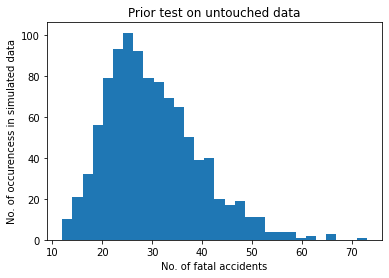

In [101]:
checking=CmdStanModel(stan_file='ppc_check.stan')

R=1000
check = checking.sample(seed=19042023,
                      fixed_param=True,
                      iter_sampling=R, 
                      iter_warmup=0,
                      chains=1)
experiment = check.draws_pd()
experiment.describe()
experiment['y_sim'].plot.hist(bins=30)
plt.title("Prior test on untouched data")
plt.xlabel("No. of fatal accidents")
plt.ylabel("No. of occurencess in simulated data")
plt.show()

Priors turned out somewhat okay. They allow some outliers but mostly are close to 'sane' values of accidents. <br>
Unfortunately using such large data was giving errors in posterior distribution, so I decided to scale it down. <br>
I will divide them by 10,000 to get unit of trillion passenger miles.

#### Prior tuning

INFO:cmdstanpy:found newer exe file, not recompiling


Mean of new miles: 0.57158


INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


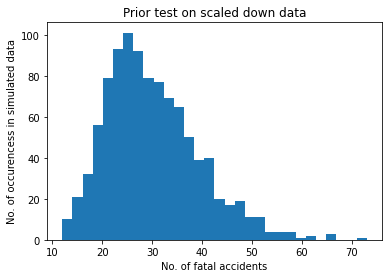

In [107]:
pd_data = pd.read_csv('Airline_data.csv')
pd_data["Miles flown [100 mln miles]"] = pd_data["Miles flown [100 mln miles]"] / 10000
print(f'''Mean of new miles: {pd_data["Miles flown [100 mln miles]"].mean()}''')


tuning=CmdStanModel(stan_file='ppc_tune.stan')

R=1000
tuned = tuning.sample(seed=19042023,
                      fixed_param=True,
                      iter_sampling=R, 
                      iter_warmup=0,
                      chains=1)
experiment = tuned.draws_pd()
experiment.describe()
experiment['y_sim'].plot.hist(bins=30)
plt.title("Prior test on scaled down data")
plt.xlabel("No. of fatal accidents")
plt.ylabel("No. of occurencess in simulated data")
plt.show()

### Posterior modeling


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


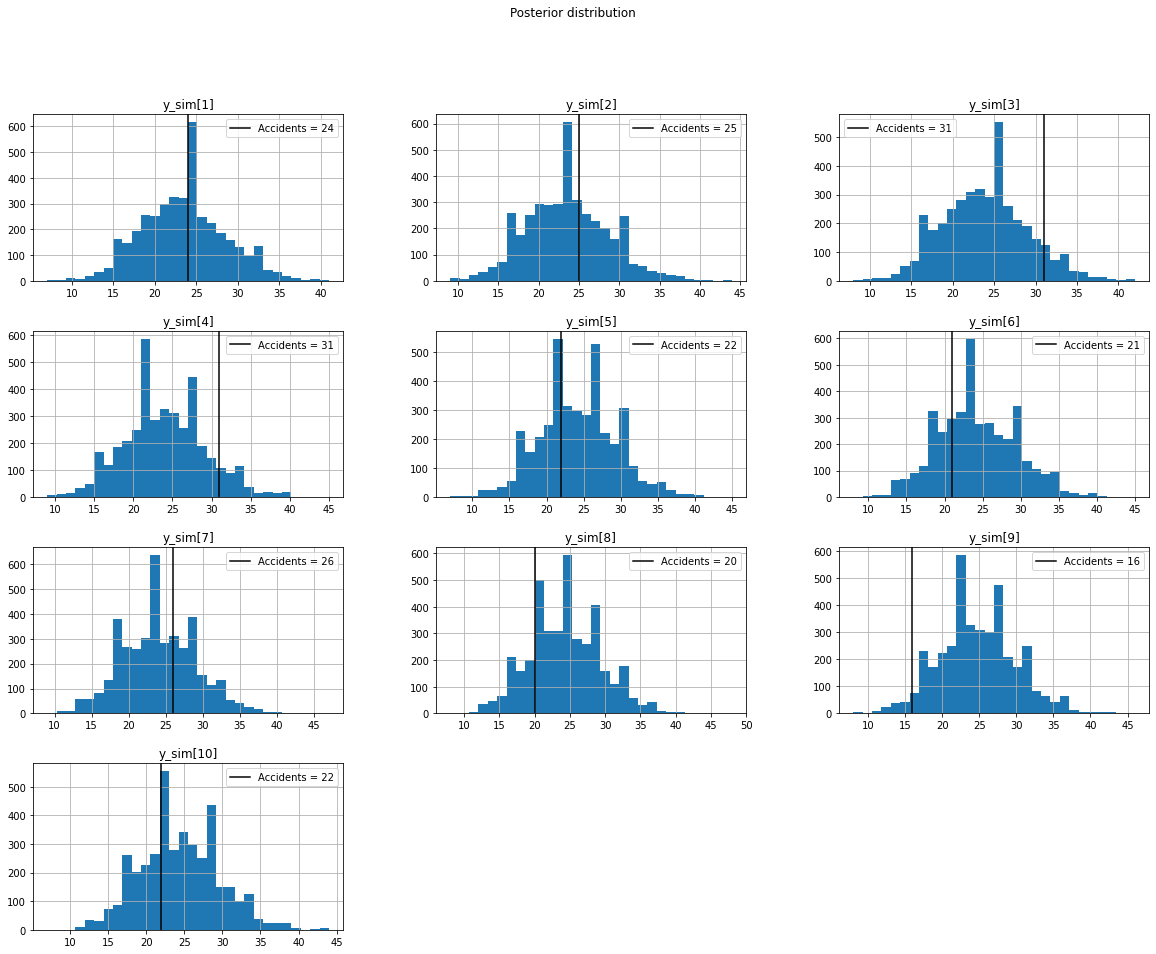

          y_sim[1]     y_sim[2]     y_sim[3]     y_sim[4]     y_sim[5]  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000   
mean     23.451500    23.487000    23.924500    23.923000    24.205000   
std       5.055694     5.065199     5.148633     5.199262     5.212607   
min       7.000000     9.000000     8.000000     9.000000     7.000000   
25%      20.000000    20.000000    20.000000    20.000000    21.000000   
50%      23.000000    23.000000    24.000000    24.000000    24.000000   
75%      27.000000    27.000000    27.000000    27.000000    28.000000   
max      41.000000    44.000000    42.000000    45.000000    45.000000   

          y_sim[6]     y_sim[7]     y_sim[8]     y_sim[9]   y_sim[10]  
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.00000  
mean     24.312250    24.073000    24.178000    24.784250    24.45325  
std       5.200722     5.013876     5.135505     5.214115     5.21048  
min       8.000000     9.000000     8.000000 

In [147]:
posterior=CmdStanModel(stan_file='posterior_one_alpha.stan')

data = {"M": len(pd_data), "miles": pd_data["Miles flown [100 mln miles]"].values, "y": pd_data["Fatal accidents"].values}

posterior_one = posterior.sample(data=data)
posterior_one_pd = posterior_one.draws_pd()


axes = posterior_one_pd.iloc[:,9:].hist(figsize=(20,15), bins=30)
axes = axes.ravel()
for idx,ax in enumerate(axes):
    if idx < 10:
        ax.axvline(pd_data["Fatal accidents"][idx], color='black', label=f'''Accidents = {pd_data["Fatal accidents"][idx]}''')
        ax.legend()
plt.suptitle("Posterior distribution")

plt.show()
print(posterior_one_pd.iloc[:,9:].describe())

This posterior is not the greatest but not bad either. Its mean values don't differ that much, this could result in bad generalisation for future data.

#### Multiple alpha parameters

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


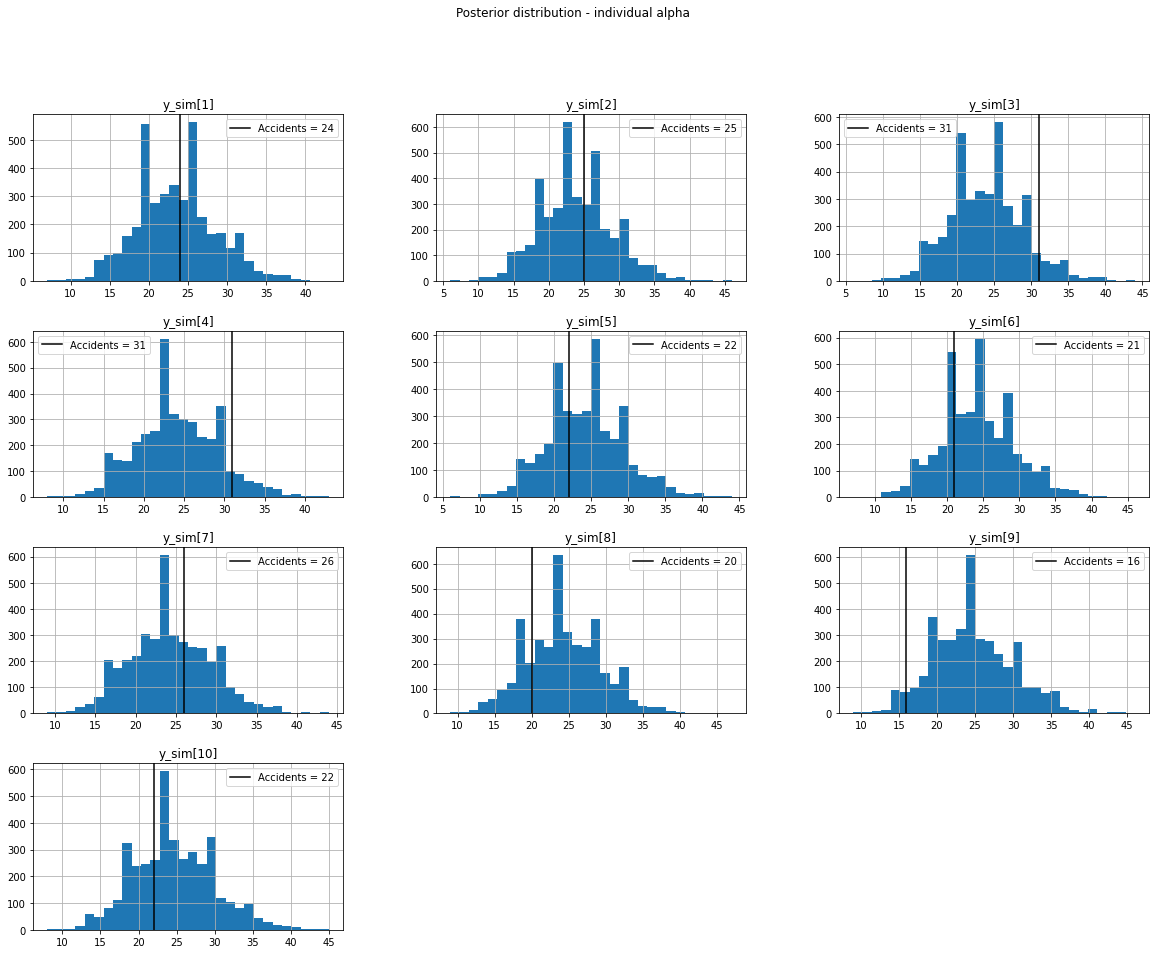

          y_sim[1]     y_sim[2]     y_sim[3]     y_sim[4]     y_sim[5]  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000   
mean     23.451500    23.487000    23.924500    23.923000    24.205000   
std       5.055694     5.065199     5.148633     5.199262     5.212607   
min       7.000000     9.000000     8.000000     9.000000     7.000000   
25%      20.000000    20.000000    20.000000    20.000000    21.000000   
50%      23.000000    23.000000    24.000000    24.000000    24.000000   
75%      27.000000    27.000000    27.000000    27.000000    28.000000   
max      41.000000    44.000000    42.000000    45.000000    45.000000   

          y_sim[6]     y_sim[7]     y_sim[8]     y_sim[9]   y_sim[10]  
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.00000  
mean     24.312250    24.073000    24.178000    24.784250    24.45325  
std       5.200722     5.013876     5.135505     5.214115     5.21048  
min       8.000000     9.000000     8.000000 

In [149]:
posterior=CmdStanModel(stan_file='posterior_multi_alpha.stan')

data = {"M": len(pd_data), "miles": pd_data["Miles flown [100 mln miles]"].values, "y": pd_data["Fatal accidents"].values}

posterior_multi = posterior.sample(data=data)
posterior_multi_pd = posterior_multi.draws_pd()


axes = posterior_multi_pd.iloc[:,18:].hist(figsize=(20,15), bins=30)
axes = axes.ravel()
for idx,ax in enumerate(axes):
    if idx < 10:
        ax.axvline(pd_data["Fatal accidents"][idx], color='black', label=f'''Accidents = {pd_data["Fatal accidents"][idx]}''')
        ax.legend()
plt.suptitle("Posterior distribution - individual alpha")

plt.show()
print(posterior_one_pd.iloc[:,9:].describe())

This model is not really different from the previous one. I assume that picking alpha as N(3.17, 0.15) was too narrow distribution. Probably giving it more 'space' could result in better fit.